In [2]:
# TODO Read data
# TODO Features and sample
# TODO Target distribution
# TODO Duplicated samples
# TODO NAs values
# TODO Explanatory features visualization
# TODO Correlation between explanatory features
# TODO Correlation explanatory features vs target
# TODO Quantitative Standarization
# TODO Qualitative Encoding? Grouping?
# TODO Feature engineering


In [3]:
import pandas as pd
import sys

In [36]:
# to load custom libraries
LIBRARY_PATH = "."
sys.path.append(LIBRARY_PATH)

# load custom libraries
from utilsPlots import plot_density, plot_bars, na_plot
#from utilsPlots import get_indexes_from_list, get_elements_from_list
#from utilsPlots import plot_anova_vs_mi

In [37]:
df_train = pd.read_csv('data/train.csv')
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [38]:
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [53]:
# Duplicated samples
dupl = sum(df_train.duplicated(['PassengerId']))
print(f'Number of duplicated ID: {dupl}')

Number of duplicated ID: 0


In [ ]:
# TODO Some Name are duplicated
sum(df_train[~df_train['Name'].isna()].duplicated(['Name']))

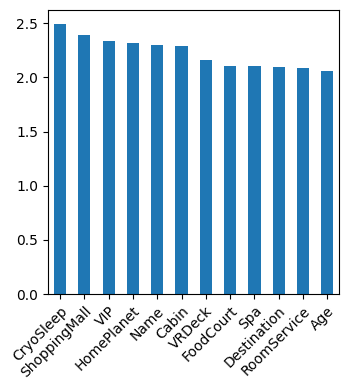

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [55]:
# NAs values
na_plot(df_train)
# TODO Imputation:
# 1. To most common
# 2. 'Unknown'
# 3. Mean --> Age
# 4. Predict Age from available data
# 5. Remove
# TODO Distribution of NAs in samples
print(df_train.isnull().sum())

In [30]:
# Distribution of target values
print(f'Number True values: {df_train["Transported"].sum()}')
print(f'Number False values: {(~df_train["Transported"]).sum()}')

Number True values: 4378
Number False values: 4315


In [31]:
features_class = {'Quantitative': ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],
                 'Qualitative': ['HomePlanet','CryoSleep','Destination','VIP']}
# TODO Something to do with Name?
# TODO Process Cabin
# Takes the form deck/num/side, where side can be either P for Port or S for Starboard

In [32]:
# TODO Separate CryoSleep True and False
# TODO Check that all CryoSleep True have no expenses
#df_train[df_train['CryoSleep'] == False]
#plot_density(df_train[df_train['CryoSleep'] == False], features_class['Quantitative'], 2, 3)
#plot_density(df_train, features_class['Quantitative'], 2, 3)

In [34]:
# TODO Distribution of Qualitative features (how many levels? imbalanced?)
df_train['VIP'] = df_train['VIP'].astype(int)
plot_bars(df_train, features_class['Qualitative'], 2, 3, sort = False)

ValueError: cannot convert float NaN to integer